In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [ ]:
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


In [ ]:
X = torch.Tensor(data.drop(columns=['Berri1','Maisonneuve_2','Maisonneuve_1']).to_numpy())
X = X[:, 3:]
y = torch.Tensor(data['Berri1'].to_numpy()).unsqueeze(1)

Let's use standard scaler on the input features to remove any biases or large numbers.

In [ ]:
scaler = preprocessing.StandardScaler()
X = torch.Tensor(scaler.fit_transform(X))

Let's Split the test and train datasets

In [ ]:
split = 0.08 # 8% train/test split

X_train = X[:int(X.shape[0]*(1-split))]
X_test = X[int(X.shape[0]*(1-split)):]

y_train = y[:int(X.shape[0]*(1-split))]
y_test = y[int(X.shape[0]*(1-split)):]
print("X:", X.shape, "y:", y.shape,
      "\nX_trn:", X_train.shape, "y_trn:", y_train.shape,
      "\nX_tst:", X_test.shape, "y_tst:", y_test.shape)


X: torch.Size([2743, 7]) y: torch.Size([2743, 1]) 
X_trn: torch.Size([2523, 7]) y_trn: torch.Size([2523, 1]) 
X_tst: torch.Size([220, 7]) y_tst: torch.Size([220, 1])


For this first model we will simply feed the data and solve a regression task.

In [ ]:
class BikeModel(torch.nn.Module):
    def __init__(self,batch_first=True):
        super(BikeModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=7, out_features=200)
        self.linear2 = torch.nn.Linear(in_features=200,out_features=200)
        self.linear3 = torch.nn.Linear(in_features=200,out_features=1)
    def forward(self, X):
        #print(X.shape)
        H = self.linear1(X)
        H = torch.nn.functional.relu(H)
        #print(H.shape)
        Z = self.linear2(H)
        H = torch.nn.functional.relu(Z)
        #print(Z.shape)
        Z = self.linear3(Z)
        H = torch.nn.functional.relu(Z)
        #print(Z.shape)
        return Z

In [ ]:
# Hyperparameters
lr = 0.001
batch_size = 29 
num_epoch = 200

# Initialize the model
ann = BikeModel()

# Initialize the Loss. 
loss = torch.nn.MSELoss()

# Initialize the Optimizer. 
optimizer = torch.optim.Adam(ann.parameters(),lr=lr, weight_decay=1e-5)

# Training Loop
for epoch in range(num_epoch):
    for i in range(0, X_train.shape[0], batch_size):

        # Read minibatches (for both X and y)
        Xi = X_train[i:i+batch_size]
        yi = y_train[i:i+batch_size]

        # Run the RNN model
        output = ann.forward(Xi)

        #     print('output',output.shape,'yi',yi.shape)
        l = loss(output,yi)

        # Update the parameters (zero_grad, backward, optimization step)
        # Your code here. Aim for 3 lines
        ann.zero_grad()
        l.backward()
        optimizer.step()

    ann.eval()
    output = ann.forward(X_test)
    l_test = loss(output, y_test)
    # Print loss
    if (epoch + 1) % 50 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))
        print("Epoch %03d: Test_loss: %.4f " %(epoch+1, l_test))


Epoch 050: Train_loss: 132278.3906 
Epoch 050: Test_loss: 3468615.0000 
Epoch 100: Train_loss: 116510.1406 
Epoch 100: Test_loss: 3471665.5000 
Epoch 150: Train_loss: 113143.1016 
Epoch 150: Test_loss: 3479784.5000 
Epoch 200: Train_loss: 110483.7031 
Epoch 200: Test_loss: 3482095.2500 


Train Data performance

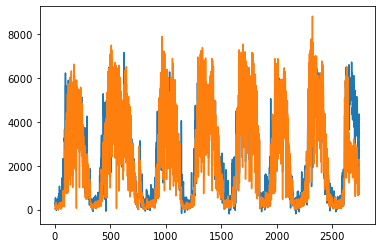

In [ ]:
import matplotlib.pyplot as plt
ann.eval()
plt.plot(ann.forward(X).detach().squeeze())
plt.plot(y.squeeze())

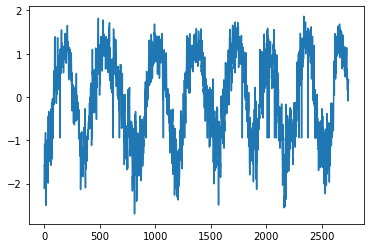

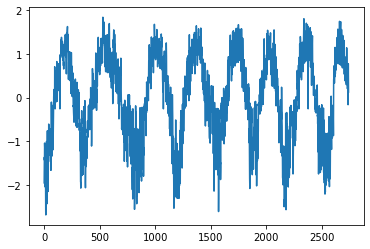

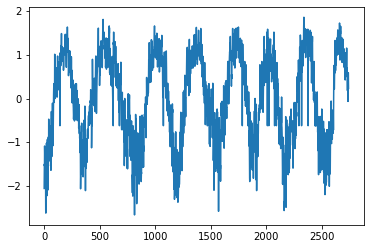

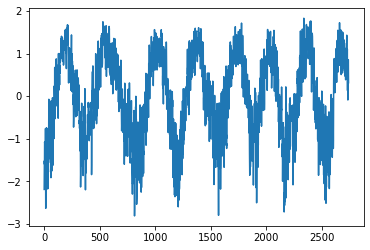

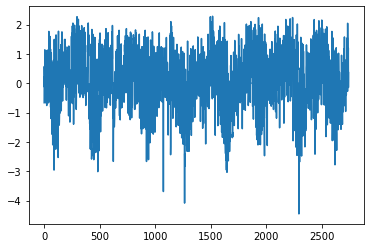

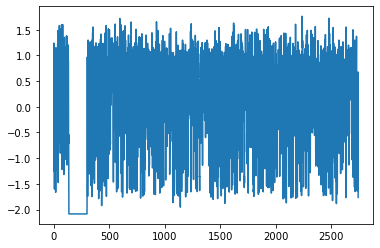

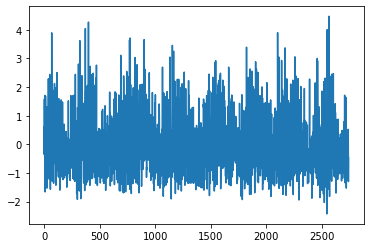

In [ ]:
for dim in range(X.shape[1]):
    plt.figure()
    plt.plot(X[:,dim])

Test data performance

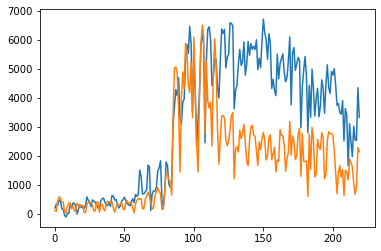

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ann.forward(X_test).detach().squeeze())
plt.plot(y_test.squeeze())